In [50]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import os.path
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.random.seed(500)

### Data Input and Visualization

Reading the input file

In [51]:
df = pd.read_csv('train.csv')

The data consist of comment_text field that stores the comment, along with it there are 6 labels namely - 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'

In [52]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Following lines drop any row which contains no data

In [53]:
df.dropna(subset=['comment_text'], inplace=True)

In [54]:
def get_label_input_count(df):
    label_input_count = [0,0,0,0,0,0,0]
    for index, row in tqdm(df.iterrows()):
        label_count = row['toxic'] + row['severe_toxic'] + row['obscene'] + row['threat'] + row['insult'] + row['identity_hate']
        label_input_count[label_count] = label_input_count[label_count] + 1

    return label_input_count

Below plot shows that more than 90% of the data is non-toxic i.e. 0 labels. Training our model with this data might give us higher accuracy, but it will give us low f1 score because our data is skewed. Therefore, to make the data less skewed, we will randomly remove 100 thousand comments with 0 labels. Doing so will still lead to having 75% of non toxic data in our dataset.

159571it [00:16, 9894.89it/s] 


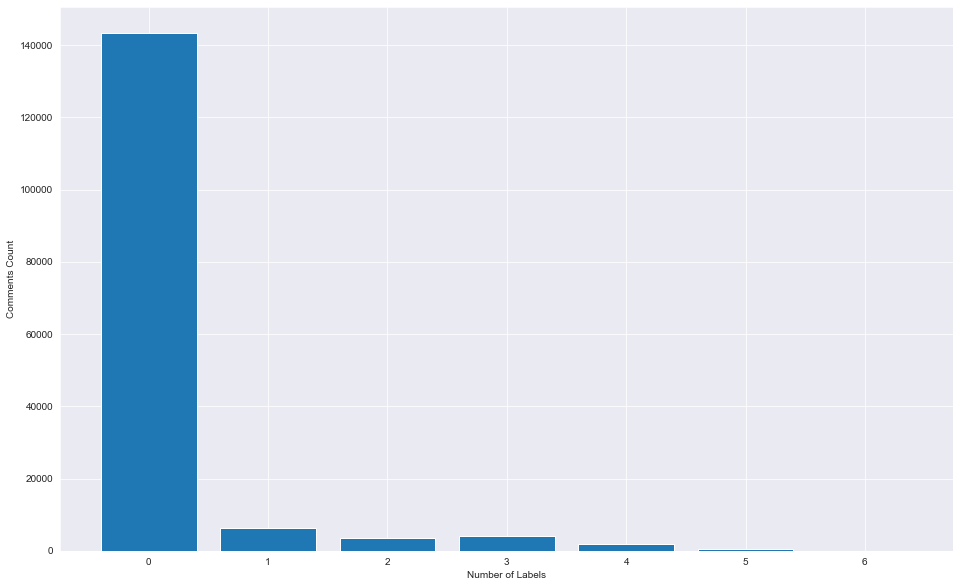

In [55]:
plt.figure(figsize=(16, 10))
plt.bar(['0', '1', '2', '3', '4', '5', '6'], get_label_input_count(df))
plt.xlabel('Number of Labels')
plt.ylabel('Comments Count')     
plt.show()

Following code randomly find 100 thousand rows with no labels and remove them from our dataset.

In [56]:
all_zero_label_data_index = []
for index, row in tqdm(df.iterrows()):
    if row['toxic'] + row['severe_toxic'] + row['obscene'] + row['threat'] + row['insult'] + row['identity_hate'] == 0:
        all_zero_label_data_index.append(index)

data_index_to_remove = random.sample(all_zero_label_data_index, k = 100000)
df.drop(data_index_to_remove, inplace = True)

159571it [00:16, 9800.83it/s] 


59571it [00:05, 10019.86it/s]


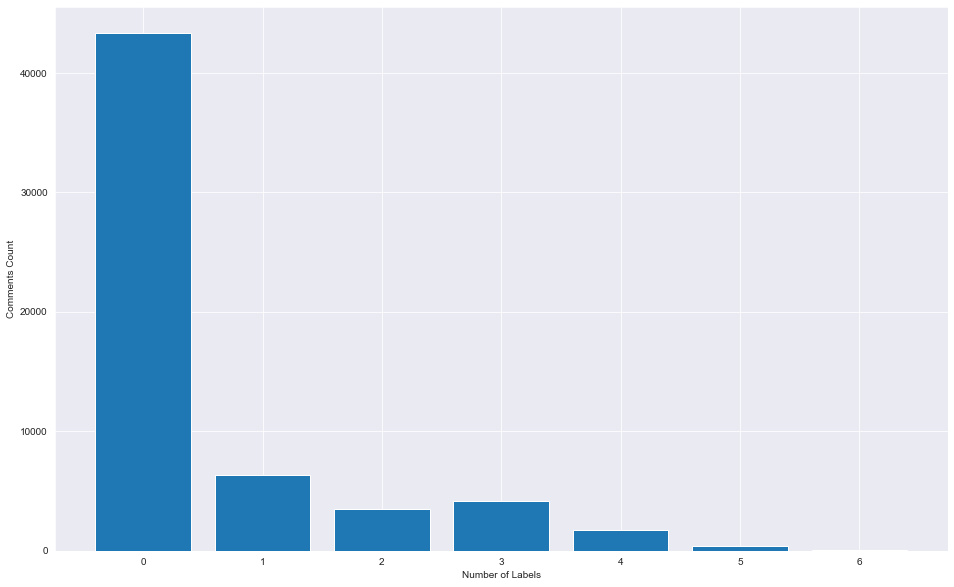

In [58]:
plt.figure(figsize=(16, 10))
plt.bar(['0', '1', '2', '3', '4', '5', '6'], get_label_input_count(df))
plt.xlabel('Number of Labels')
plt.ylabel('Comments Count')     
plt.show()

### Data Preprocessing
1. Making the comment text lowercase
2. Splitting the comments into individual words i.e Performing tokenization
3. Removing Stop words
4. Lemmatization
5. Splitting the data into train and test

Below code make all comments lowercase

In [10]:
df['comment_text'] = [entry.lower() for entry in df['comment_text']]
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
12,0005c987bdfc9d4b,hey... what is it..\n@ | talk .\nwhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"bye! \n\ndon't look, come or think of comming ...",1,0,0,0,0,0


Below code tokenize the data

In [11]:
df['tokenized_comment_text']= [word_tokenize(entry) for entry in tqdm(df['comment_text'])]
df.head()

100%|██████████| 59571/59571 [00:29<00:00, 2014.25it/s]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokenized_comment_text
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,"[hey, man, ,, i, 'm, really, not, trying, to, ..."
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,"[cocksucker, before, you, piss, around, on, my..."
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,"[alignment, on, this, subject, and, which, are..."
12,0005c987bdfc9d4b,hey... what is it..\n@ | talk .\nwhat is it......,1,0,0,0,0,0,"[hey, ..., what, is, it.., @, |, talk, ., what..."
16,0007e25b2121310b,"bye! \n\ndon't look, come or think of comming ...",1,0,0,0,0,0,"[bye, !, do, n't, look, ,, come, or, think, of..."


Below code performs the Lemmatization over data and also removes the stop words

In [12]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [15]:
from tqdm import tqdm
if os.path.isfile('preprocess_pickle.pkl'):
    df = pd.read_pickle('preprocess_pickle.pkl');
else:
    final_comment_text = []
    for entry in tqdm(df['tokenized_comment_text']):
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        final_comment_text.append(Final_words)
    # The final processed set of words for each iteration will be stored in 'comment_text_final'
    df['comment_text_final'] = final_comment_text
    df.to_pickle("preprocess_pickle.pkl")

In [17]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokenized_comment_text,comment_text_final
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,"[hey, man, ,, i, 'm, really, not, trying, to, ...","[hey, man, really, try, edit, war, guy, consta..."
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,"[cocksucker, before, you, piss, around, on, my...","[cocksucker, piss, around, work]"
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,"[alignment, on, this, subject, and, which, are...","[alignment, subject, contrary, dulithgow]"
12,0005c987bdfc9d4b,hey... what is it..\n@ | talk .\nwhat is it......,1,0,0,0,0,0,"[hey, ..., what, is, it.., @, |, talk, ., what...","[hey, talk, exclusive, group, wp, taliban, goo..."
16,0007e25b2121310b,"bye! \n\ndon't look, come or think of comming ...",1,0,0,0,0,0,"[bye, !, do, n't, look, ,, come, or, think, of...","[bye, look, come, think, comming, back, tosser]"


Below code splits the data into train and test

In [21]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X_train, X_test, y_train, y_test = train_test_split(df['comment_text_final'], 
                                                    df[label_cols], test_size=0.33, random_state=42)

In [28]:
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
y_train.to_pickle("y_train.pkl")
y_test.to_pickle("y_test.pkl")